In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn --quiet

import os
import json
from typing import List, Dict, Any

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
import kagglehub
WEST_ROOT = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
print("Western root:", os.listdir(WEST_ROOT))

Using Colab cache for faster access to the 'fashion-product-images-small' dataset.
Western root: ['myntradataset', 'images', 'styles.csv']


In [ ]:
import kagglehub
INDO_ROOT = kagglehub.dataset_download("validmodel/indo-fashion-dataset")
print("Indo root:", os.listdir(INDO_ROOT))

100%|██████████| 2.69G/2.69G [00:40<00:00, 71.3MB/s]

Extracting files...


Indo root: ['images', 'test_data.json', 'train_data.json', 'val_data.json']


In [ ]:
def load_json_records(json_path: str) -> List[Dict[str, Any]]:
    records = []
    with open(json_path, "r") as f:
        raw = f.read().strip()
        if not raw:
            return records

        if raw[0] == "[":
            # JSON array
            records = json.loads(raw)
        else:
            # JSON Lines
            for line in raw.splitlines():
                line = line.strip()
                if not line:
                    continue
                records.append(json.loads(line))
    return records

indo_train_meta = load_json_records(os.path.join(INDO_ROOT, "train_data.json"))
indo_val_meta   = load_json_records(os.path.join(INDO_ROOT, "val_data.json"))
indo_test_meta  = load_json_records(os.path.join(INDO_ROOT, "test_data.json"))

print("IndoFashion – train/val/test:", len(indo_train_meta), len(indo_val_meta), len(indo_test_meta))
print("Sample Indo record:", indo_train_meta[0])


IndoFashion – train/val/test: 91166 7500 7500
Sample Indo record: {'image_url': 'https://m.media-amazon.com/images/I/81XKaSKvlyL._AC_UL320_.jpg', 'image_path': 'images/train/0.jpeg', 'brand': 'Womanista', 'product_title': "Women's Georgette Saree with Blouse Piece (TKIM811_Black_Free Size)", 'class_label': 'saree'}


In [ ]:
styles_path = os.path.join(WEST_ROOT, "styles.csv")
western_df = pd.read_csv(styles_path, on_bad_lines="skip")
print("Western rows:", len(western_df))
print(western_df.head())
print("Columns:", western_df.columns)


Western rows: 44424
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
Columns: Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season'

In [ ]:
# Most images are inside WEST_ROOT/images/
IMG_DIR_WEST = os.path.join(WEST_ROOT, "images")

def western_image_exists(row):
    img_name = str(row["id"]) + ".jpg"
    return os.path.exists(os.path.join(IMG_DIR_WEST, img_name))

western_df = western_df[western_df.apply(western_image_exists, axis=1)].reset_index(drop=True)
print("Western rows with existing images:", len(western_df))


Western rows with existing images: 44419


In [ ]:
def normalize_type_indo(class_label: str) -> str:
    """Map IndoFashion class_label to a unified type name."""
    s = class_label.strip().lower()
    # Examples – adjust as per actual Indo labels:
    if "saree" in s or "sari" in s:
        return "saree"
    if "kurti" in s or "kurta" in s:
        return "kurti"
    if "lehenga" in s:
        return "lehenga"
    if "gown" in s:
        return "gown"
    if "blouse" in s:
        return "blouse"
    if "sherwani" in s:
        return "sherwani"
    if "salwar" in s:
        return "salwar"
    if "top" in s:
        return "top"
    if "shirt" in s:
        return "shirt"
    if "tshirt" in s or "t-shirt" in s:
        return "tshirt"
    if "jean" in s or "denim" in s:
        return "jeans"
    if "trouser" in s or "pant" in s:
        return "trouser"
    if "skirt" in s:
        return "skirt"
    if "dress" in s:
        return "dress"
    if "jacket" in s or "coat" in s or "blazer" in s:
        return "jacket"
    # fallback
    return s

def normalize_type_west(article_type: str) -> str:
    """Map Fashion Product Images 'articleType' to unified type name."""
    s = str(article_type).strip().lower()
    if "saree" in s or "sari" in s:
        return "saree"
    if "kurta" in s or "kurti" in s:
        return "kurti"
    if "lehenga" in s:
        return "lehenga"
    if "gown" in s:
        return "gown"
    if "blouse" in s:
        return "blouse"
    if "sherwani" in s:
        return "sherwani"
    if "salwar" in s or "churidar" in s:
        return "salwar"
    if "shirt" in s:
        return "shirt"
    if "t-shirt" in s or "tshirt" in s or "tee" in s:
        return "tshirt"
    if "jeans" in s or "denim" in s:
        return "jeans"
    if "trouser" in s or "pant" in s or "chinos" in s:
        return "trouser"
    if "skirt" in s:
        return "skirt"
    if "dress" in s or "onepiece" in s:
        return "dress"
    if "jacket" in s or "coat" in s or "blazer" in s:
        return "jacket"
    if "top" in s or "tank" in s or "camisole" in s:
        return "top"
    # fallback
    return s


In [ ]:
def get_indo_color(rec: Dict[str, Any]) -> str:
    # Indo records may contain "colour" or "color"
    c = rec.get("colour", rec.get("color", None))
    if c is None:
        return "other"
    return str(c).strip().lower()

def get_west_color(row: pd.Series) -> str:
    # Fashion Product Images usually has "baseColour"
    c = row.get("baseColour", None)
    if pd.isna(c):
        return "other"
    return str(c).strip().lower()


In [ ]:
def infer_gender_from_type(type_name: str) -> str:
    t = type_name.lower()
    women_only = {"saree", "lehenga", "gown", "kurti", "skirt", "blouse", "salwar", "dress"}
    men_only   = {"sherwani", "blazer_men"}  # extend if needed

    if t in women_only:
        return "Women"
    if t in men_only:
        return "Men"
    # everything else treated as Unisex (shirt, tshirt, jeans, jacket, etc.)
    return "Unisex"


In [ ]:
# 1) Collect unified types
types_indo = {normalize_type_indo(rec["class_label"]) for rec in indo_train_meta}
types_west = {normalize_type_west(t) for t in western_df["articleType"].unique()}

unified_types = sorted(types_indo.union(types_west))
print("Unified Types (count):", len(unified_types))
print(unified_types)

type_to_id = {name: idx for idx, name in enumerate(unified_types)}
id_to_type = {idx: name for name, idx in type_to_id.items()}

NUM_TYPES = len(type_to_id)
print("NUM_TYPES:", NUM_TYPES)

# 2) Collect unified colors
colors_indo = {get_indo_color(r) for r in indo_train_meta}
colors_west = {get_west_color(row) for _, row in western_df.iterrows()}
unified_colors = sorted(set(colors_indo).union(colors_west).union({"other"}))

color_to_id = {name: idx for idx, name in enumerate(unified_colors)}
id_to_color = {idx: name for name, idx in color_to_id.items()}

NUM_COLORS = len(color_to_id)
print("NUM_COLORS:", NUM_COLORS)
print("Sample colors:", unified_colors[:15])

# 3) Gender mapping (fixed)
gender_to_id = {"Men": 0, "Women": 1, "Unisex": 2}
id_to_gender = {v: k for k, v in gender_to_id.items()}
NUM_GENDERS = len(gender_to_id)
print("NUM_GENDERS:", NUM_GENDERS, gender_to_id)


Unified Types (count): 132
['accessory gift set', 'baby dolls', 'backpacks', 'bangle', 'basketballs', 'bath robe', 'beauty accessory', 'belts', 'blouse', 'body lotion', 'body wash and scrub', 'booties', 'boxers', 'bra', 'bracelet', 'briefs', 'capris', 'caps', 'casual shoes', 'clothing set', 'clutches', 'compact', 'concealer', 'cufflinks', 'cushion covers', 'deodorant', 'dress', 'duffel bag', 'dupatta', 'dupattas', 'earrings', 'eye cream', 'eyeshadow', 'face moisturisers', 'face scrub and exfoliator', 'face serum and gel', 'face wash and cleanser', 'flats', 'flip flops', 'footballs', 'formal shoes', 'foundation and primer', 'fragrance gift set', 'free gifts', 'gloves', 'gown', 'hair accessory', 'hair colour', 'handbags', 'hat', 'headband', 'heels', 'highlighter and blush', 'innerwear vests', 'ipad', 'jacket', 'jeans', 'jeggings', 'jewellery set', 'jumpsuit', 'kajal and eyeliner', 'key chain', 'kurti', 'leggings', 'lehenga', 'lip care', 'lip gloss', 'lip liner', 'lip plumper', 'lipstick'

In [ ]:
# Format of each sample:
# {
#   "img_path": ...,
#   "type_id": ...,
#   "color_id": ...,
#   "gender_id": ...
# }

def build_indo_samples(meta_list: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    samples = []
    for rec in meta_list:
        # image path
        img_rel_path = rec["image_path"]   # e.g., "images/train/xxxx.jpg"
        img_path = os.path.join(INDO_ROOT, img_rel_path)

        # type
        raw_type = rec["class_label"]
        unified_type = normalize_type_indo(raw_type)
        if unified_type not in type_to_id:
            continue
        type_id = type_to_id[unified_type]

        # color
        raw_color = get_indo_color(rec)
        if raw_color not in color_to_id:
            raw_color = "other"
        color_id = color_to_id[raw_color]

        # gender (inferred from type)
        gender_str = infer_gender_from_type(unified_type)
        gender_id = gender_to_id[gender_str]

        samples.append({
            "img_path": img_path,
            "type_id": type_id,
            "color_id": color_id,
            "gender_id": gender_id,
        })
    return samples

indo_train_samples = build_indo_samples(indo_train_meta)
indo_val_samples   = build_indo_samples(indo_val_meta)
indo_test_samples  = build_indo_samples(indo_test_meta)

len(indo_train_samples), len(indo_val_samples), len(indo_test_samples)


(91166, 7500, 7500)

In [ ]:
def build_west_samples(df: pd.DataFrame) -> List[Dict[str, Any]]:
    samples = []
    for _, row in df.iterrows():
        img_name = str(row["id"]) + ".jpg"
        img_path = os.path.join(IMG_DIR_WEST, img_name)
        if not os.path.exists(img_path):
            continue

        raw_type = row["articleType"]
        unified_type = normalize_type_west(raw_type)
        if unified_type not in type_to_id:
            continue
        type_id = type_to_id[unified_type]

        raw_color = get_west_color(row)
        if raw_color not in color_to_id:
            raw_color = "other"
        color_id = color_to_id[raw_color]

        gender_str = infer_gender_from_type(unified_type)
        gender_id = gender_to_id[gender_str]

        samples.append({
            "img_path": img_path,
            "type_id": type_id,
            "color_id": color_id,
            "gender_id": gender_id,
        })
    return samples

west_all_samples = build_west_samples(western_df)
len(west_all_samples)


44419

In [ ]:
train_west, temp_west = train_test_split(west_all_samples, test_size=0.3, random_state=42)
val_west, test_west   = train_test_split(temp_west, test_size=0.5, random_state=42)

len(train_west), len(val_west), len(test_west)


(31093, 6663, 6663)

In [ ]:
train_samples = indo_train_samples + train_west
val_samples   = indo_val_samples   + val_west
test_samples  = indo_test_samples  + test_west

print("Combined train/val/test sizes:", len(train_samples), len(val_samples), len(test_samples))


Combined train/val/test sizes: 122259 14163 14163


In [ ]:
IMG_SIZE = 128

transform_main = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5]),
])

class StyleSyncDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform if transform is not None else transform_main

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rec = self.samples[idx]
        img_path = rec["img_path"]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        labels = {
            "type":   torch.tensor(rec["type_id"],   dtype=torch.long),
            "color":  torch.tensor(rec["color_id"],  dtype=torch.long),
            "gender": torch.tensor(rec["gender_id"], dtype=torch.long),
        }
        return img, labels

train_ds = StyleSyncDataset(train_samples)
val_ds   = StyleSyncDataset(val_samples)
test_ds  = StyleSyncDataset(test_samples)

len(train_ds), len(val_ds), len(test_ds)


(122259, 14163, 14163)

{'type': tensor(94), 'color': tensor(228), 'gender': tensor(1)}


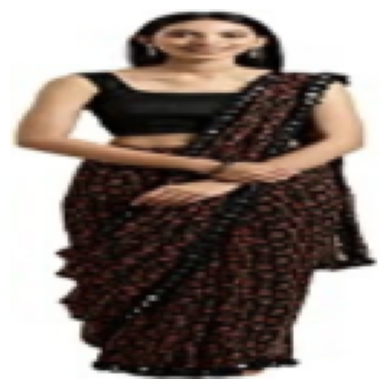

In [ ]:
img, labels = train_ds[0]
print(labels)
plt.imshow(img.permute(1,2,0).cpu().numpy() * 0.5 + 0.5)
plt.axis("off")
plt.show()


In [ ]:
BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Batches → Train:", len(train_loader), "Val:", len(val_loader), "Test:", len(test_loader))


Batches → Train: 1911 Val: 222 Test: 222


In [ ]:
class MultiTaskResNet(nn.Module):
    def __init__(self,
                 backbone_name="resnet18",
                 pretrained=True,
                 num_types=NUM_TYPES,
                 num_colors=NUM_COLORS,
                 num_genders=NUM_GENDERS):
        super().__init__()
        backbone = getattr(models, backbone_name)(pretrained=pretrained)
        # Remove final FC
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # (B, 512, 1, 1)
        feat_dim = backbone.fc.in_features  # 512 for resnet18

        self.shared_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.type_head   = nn.Linear(512, num_types)
        self.color_head  = nn.Linear(512, num_colors)
        self.gender_head = nn.Linear(512, num_genders)

    def forward(self, x):
        f = self.backbone(x)
        s = self.shared_fc(f)
        t = self.type_head(s)
        c = self.color_head(s)
        g = self.gender_head(s)
        return t, c, g

model = MultiTaskResNet().to(DEVICE)
print("Model created on:", DEVICE)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Model created on: cuda


In [ ]:
criterion_type   = nn.CrossEntropyLoss()
criterion_color  = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

ALPHA, BETA, GAMMA = 0.5, 0.25, 0.25   # type, color, gender
EPOCHS = 15


def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(DEVICE)
        t_lbl = labels["type"].to(DEVICE)
        c_lbl = labels["color"].to(DEVICE)
        g_lbl = labels["gender"].to(DEVICE)

        optimizer.zero_grad()
        out_t, out_c, out_g = model(imgs)

        L_type   = criterion_type(out_t, t_lbl)
        L_color  = criterion_color(out_c, c_lbl)
        L_gender = criterion_gender(out_g, g_lbl)

        loss = ALPHA * L_type + BETA * L_color + GAMMA * L_gender
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


def evaluate(model, loader):
    model.eval()
    total_loss = 0.0

    all_type_true, all_type_pred     = [], []
    all_color_true, all_color_pred   = [], []
    all_gender_true, all_gender_pred = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs = imgs.to(DEVICE)
            t_lbl = labels["type"].to(DEVICE)
            c_lbl = labels["color"].to(DEVICE)
            g_lbl = labels["gender"].to(DEVICE)

            out_t, out_c, out_g = model(imgs)

            L_type   = criterion_type(out_t, t_lbl)
            L_color  = criterion_color(out_c, c_lbl)
            L_gender = criterion_gender(out_g, g_lbl)

            loss = ALPHA * L_type + BETA * L_color + GAMMA * L_gender
            total_loss += loss.item() * imgs.size(0)

            all_type_true.extend(t_lbl.cpu().numpy())
            all_color_true.extend(c_lbl.cpu().numpy())
            all_gender_true.extend(g_lbl.cpu().numpy())

            all_type_pred.extend(out_t.argmax(dim=1).cpu().numpy())
            all_color_pred.extend(out_c.argmax(dim=1).cpu().numpy())
            all_gender_pred.extend(out_g.argmax(dim=1).cpu().numpy())

    metrics = {
        "loss":       total_loss / len(loader.dataset),
        "type_acc":   accuracy_score(all_type_true,   all_type_pred),
        "color_acc":  accuracy_score(all_color_true,  all_color_pred),
        "gender_acc": accuracy_score(all_gender_true, all_gender_pred),
    }
    return metrics


In [ ]:
history = []
best_val_type_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_metrics = evaluate(model, val_loader)

    history.append((train_loss, val_metrics))

    print(
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_metrics['loss']:.4f} | "
        f"Type Acc: {val_metrics['type_acc']:.3f} | "
        f"Color Acc: {val_metrics['color_acc']:.3f} | "
        f"Gender Acc: {val_metrics['gender_acc']:.3f}"
    )

    if val_metrics["type_acc"] > best_val_type_acc:
        best_val_type_acc = val_metrics["type_acc"]
        torch.save(model.state_dict(), "stylesync_combined_best.pt")
        print("✅ Saved best model checkpoint")



Epoch 1/15


Train Loss: 0.6418 | Val Loss: 0.4882 | Type Acc: 0.846 | Color Acc: 0.770 | Gender Acc: 0.947
✅ Saved best model checkpoint

Epoch 2/15


Train Loss: 0.3675 | Val Loss: 0.4197 | Type Acc: 0.867 | Color Acc: 0.796 | Gender Acc: 0.956
✅ Saved best model checkpoint

Epoch 3/15


Train Loss: 0.2957 | Val Loss: 0.4011 | Type Acc: 0.870 | Color Acc: 0.807 | Gender Acc: 0.955
✅ Saved best model checkpoint

Epoch 4/15


Train Loss: 0.2481 | Val Loss: 0.3905 | Type Acc: 0.876 | Color Acc: 0.821 | Gender Acc: 0.958
✅ Saved best model checkpoint

Epoch 5/15


Train Loss: 0.2138 | Val Loss: 0.3975 | Type Acc: 0.877 | Color Acc: 0.816 | Gender Acc: 0.957
✅ Saved best model checkpoint

Epoch 6/15


Train Loss: 0.1888 | Val Loss: 0.4184 | Type Acc: 0.879 | Color Acc: 0.817 | Gender Acc: 0.957
✅ Saved best model checkpoint

Epoch 7/15


Train Loss: 0.1668 | Val Loss: 0.4504 | Type Acc: 0.873 | Color Acc: 0.813 | Gender Acc: 0.955

Epoch 8/15


Train Loss: 0.1504 | Val Loss: 0.4575 | Type Acc: 0.870 | Color Acc: 0.817 | Gender Acc: 0.955

Epoch 9/15


Train Loss: 0.1359 | Val Loss: 0.4615 | Type Acc: 0.877 | Color Acc: 0.812 | Gender Acc: 0.956

Epoch 10/15


Train Loss: 0.1264 | Val Loss: 0.5172 | Type Acc: 0.875 | Color Acc: 0.801 | Gender Acc: 0.953

Epoch 11/15


Train Loss: 0.1170 | Val Loss: 0.4959 | Type Acc: 0.874 | Color Acc: 0.817 | Gender Acc: 0.954

Epoch 12/15


Train Loss: 0.1116 | Val Loss: 0.5263 | Type Acc: 0.875 | Color Acc: 0.804 | Gender Acc: 0.953

Epoch 13/15


Train Loss: 0.1031 | Val Loss: 0.5464 | Type Acc: 0.872 | Color Acc: 0.812 | Gender Acc: 0.953

Epoch 14/15


Train Loss: 0.0989 | Val Loss: 0.5610 | Type Acc: 0.874 | Color Acc: 0.807 | Gender Acc: 0.953

Epoch 15/15


Train Loss: 0.0953 | Val Loss: 0.5419 | Type Acc: 0.877 | Color Acc: 0.813 | Gender Acc: 0.954


In [ ]:
def load_best_model():
    m = MultiTaskResNet(pretrained=False).to(DEVICE)
    m.load_state_dict(torch.load("stylesync_combined_best.pt", map_location=DEVICE))
    m.eval()
    return m

best_model = load_best_model()
test_metrics = evaluate(best_model, test_loader)

print("\nTEST METRICS (Combined Indo + Western):")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
                                                       


TEST METRICS (Combined Indo + Western):
loss: 0.4155
type_acc: 0.8808
color_acc: 0.8173
gender_acc: 0.9575


In [ ]:
def eval_type_only(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            t_lbl = labels["type"].to(DEVICE)
            out_t, _, _ = model(imgs)
            y_true.extend(t_lbl.cpu().numpy())
            y_pred.extend(out_t.argmax(dim=1).cpu().numpy())
    return y_true, y_pred

y_true, y_pred = eval_type_only(best_model, test_loader)
print(classification_report(y_true, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.917     1.000     0.957        11
           1      0.000     0.000     0.000         3
           2      0.934     0.911     0.922       124
           3      0.714     1.000     0.833        10
           4      0.333     1.000     0.500         1
           5      1.000     0.333     0.500         3
           7      1.000     0.991     0.995       107
           8      0.962     0.966     0.964       500
           9      0.000     0.000     0.000         1
          10      0.000     0.000     0.000         1
          11      0.000     0.000     0.000         0
          12      1.000     0.250     0.400         4
          13      0.984     0.984     0.984        62
          14      1.000     0.167     0.286         6
          15      0.992     0.968     0.980       125
          16      0.850     0.531     0.654        32
          17      0.977     0.977     0.977        43
          18      0.834    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

Predicted Type:   saree (99.53%)
Predicted Color:  other (50.30%)
Predicted Gender: Women (99.89%)


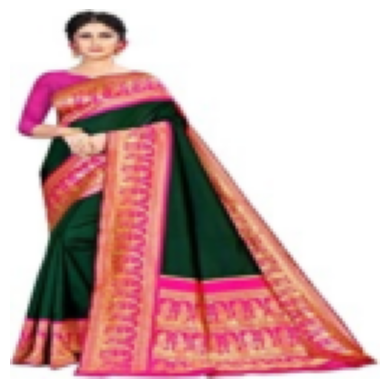

In [ ]:
def predict_sample(ds, index):
    img, labels = ds[index]
    x = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out_t, out_c, out_g = best_model(x)
        pt = F.softmax(out_t, dim=1)[0]
        pc = F.softmax(out_c, dim=1)[0]
        pg = F.softmax(out_g, dim=1)[0]

    t_idx = pt.argmax().item()
    c_idx = pc.argmax().item()
    g_idx = pg.argmax().item()

    print(f"Predicted Type:   {id_to_type[t_idx]} ({pt[t_idx].item()*100:.2f}%)")
    print(f"Predicted Color:  {id_to_color[c_idx]} ({pc[c_idx].item()*100:.2f}%)")
    print(f"Predicted Gender: {id_to_gender[g_idx]} ({pg[g_idx].item()*100:.2f}%)")

    plt.imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    plt.axis("off")
    plt.show()

# Example:
predict_sample(test_ds, 10)
